# CygnusX

In [2]:
import aplpy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


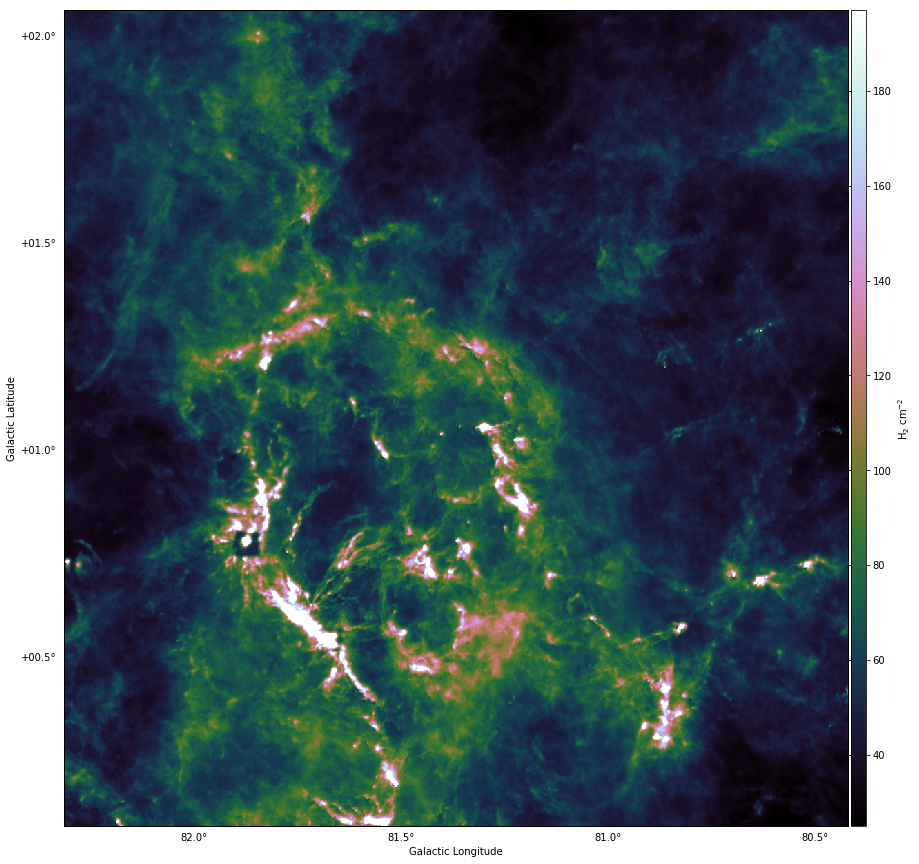

In [3]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/Ken_Marsh/CygnusX-DR21_l081_cdens_cut_nan.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta')
fig.show_colorscale(vmin=25,vmax=197,cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [4]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
output_notebook()

from astropy.io import fits
from astropy import wcs
from powspec import powspec
from wavan import fan_trans, apodize, padding, depad
from rebin import congrid
from gauss_beam import gauss_beam

Loading BokehJS ...

In [5]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [11]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
im -= np.mean(im)

#Apodization

tapper = apodize(nb,na,0.95)
imt = im *tapper
imr = padding(imt,1500,1500)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
#FWHM = 36. / (60.*reso)  #Beam size at 500 micron
#beam=gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
#tab_k, spec_beam = powspec(beam, reso=reso)
#spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
#del Bwt,BS11a,Bq
#BS1an = BS1a * BS1a[5]

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_k, legend='Fourier')

#Set a list of q
q=[]
q[0:4]=[1.4]*5
q[5:25]=[2.5]*20
#q=[2.5]*25
print q

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True)
#wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, apodize= 0.98, arrdim = np.array([1500,1500]))

#S1an[0,4:] = S1a[0,4:]/BS1an[4:]
#S1an[1,4:] = S1a[1,4:]/BS1an[4:]
#S1an[2,4:] = S1a[2,4:]/BS1an[4:]

f.diamond(wav_k, S1a[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1a[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1a[2,:], legend='Gaussian',color='red',line_width=5)

#Power law fit
coef = np.polyfit(np.log(wav_k[5:16]),np.log(S1a[2,5:16]),deg=1)
yfit = np.exp(coef[1])*wav_k**coef[0]

print "Power law = ", coef[0]

f.line(wav_k, yfit, legend='Fit',line_dash='dashed')

showbok(f)

[1.4, 1.4, 1.4, 1.4, 1.4, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]
Power law =  -3.19922815313885


[1.4, 1.4, 1.4, 1.4, 1.4, 1.5999999999999992, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996, 2.0999999999999996, 2.0999999999999996, 2.0999999999999996, 2.0999999999999996, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.5]
wav_k.shape[0]= 24


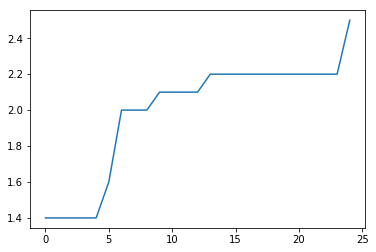

In [14]:
print q
print 'wav_k.shape[0]=',wav_k.shape[0]

x = range(25)
plot(x,np.array(q).reshape(25))

In [15]:
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wt.npy',wt)
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S11a.npy',S11a)
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wav_k.npy',wav_k)
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S1a.npy',S1a)
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_q.npy',q)

INFO: Auto-setting vmin to -4.986e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.389e+01 [aplpy.core]
INFO: Auto-setting vmin to -8.125e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.722e+02 [aplpy.core]


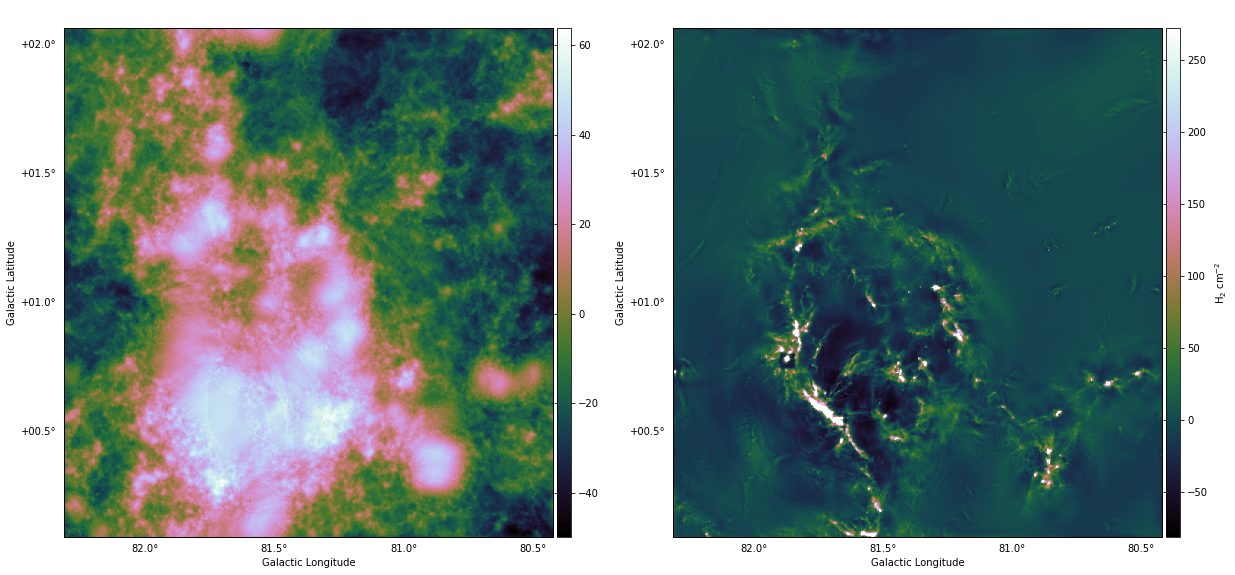

In [12]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_cohe.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_gaussian.fits',\
            Gaussian.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,10))

figfile = '/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')